# 擬似lyapunov指数のプログラムについて

計算途中で得られるリャプノフ指数の順番には特に意味はないと思われる.
そのためsortして大小の順で系列化してそれらの変遷をみることができる.

LLPは短時間の平均値, GLPは長時間の平均値であり, ここではLLPの平均をとって計算している.
GLPを計算するために各ステップにおけるLLPを計算する. LLPの計算法はnum_stepsで指定した回数だけ後のステップのJcobianの積を計算し, その固有値の平均値より算出する.


多次元ニュートンラフソン法(ヤコビアンの数値計算)
https://chemical-engineering-review.com/python-multivariate-newton-raphson/

ヤコビ法: 連立方程式の数値解法
https://org-technology.com/posts/solving-linear-equations-yacobi.html

数値解法のヤコビアン
https://www.youtube.com/watch?v=wI5FQD3uIDg


jacobian for 1 output func
def jacobian(f, x, dx):#x: vector, dx: differential direction
  return (f(x+dx)-f(x))/abs(x)*dx

ある特定のパラメータ下において、
十分長い時間領域におけるリャプノフ指数
を計算するのに特化している.
時系列は得られない.

これは擬似リャプノフ指数である。
擬似リャプノフ指数って何?->入力が毎ステップ入ることでシステムそのものの特徴を反映できなくなるから.
純粋なリャプノフ指数ではない.
ESNのプログラムを参考に、時系列だけCMLに変えたもの.
このプログラムを書くことでリャプノフ指数の計算を理解したつもり.


# init

In [1]:

def func1(r, x):
  return r*x*(1-x)

def logistic(a, x):
  return 1-(a*x)*x

def next_x(f, r, l, eps, x):
    x_new = np.empty(x.shape)
    for i in range(l):
        if i == 0:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i+1])
        elif i == l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i-1])
        elif i > 0 and i < l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + 0.5 * eps * (f(r,x[i-1]) + f(r,x[i+1]))
            #ここの0.5は必要か??
    return x_new


In [2]:
from numpy import linalg as LA
import numpy as np
#dim_rv: length of state, like CML, GCM, ESN

delta=0.001
def jacobian(f, r, x, dx):#x: vector, dx: differential direction
  return (f(r, x+dx)-f(r, x))/np.linalg.norm(dx)

def pseudo_lyp_spectrum(dim_rv=2, num_steps=10,h=delta, r=4.0, eps=0.1):

  nTransients = 2000   # The iterates we'll throw away
  nIterates = 4000       # This sets how dense the bifurcation diagram will be
  ic = np.random.uniform(0.1, 0.9, dim_rv)  # random initial condition betn. (0,1)

  for i in range(nTransients):
    ic=next_x(func1, r, dim_rv, eps, ic)

  state_list=np.empty((nIterates, dim_rv))
  state_list[0]=ic
  for i in range(nIterates-1):
    state_list[i+1]=next_x(func1, r, dim_rv, eps, state_list[i])

  #print(state_list.shape)
  lyp_spec = []
    
  L = state_list.shape[0]
  dx_list=np.identity(dim_rv)*h
  for i in range(0, L, num_steps):
    ps_lyp = np.zeros(dim_rv)
    for k in range(i, min(i+num_steps, L)):
      # Calculate the Jacobian matrix
      J_f = []
      for j in range(dim_rv):
        J_f.append(jacobian(func1, r, state_list[k], dx_list[j]))
      J_f=np.array(J_f).T
      # Calculate the spectrum of the Jacobian matrix
      A = np.dot(J_f, np.transpose(J_f))
      # Now A is a real symmetrix matrix, the eigenvalues will be real number
      # We take the square root of absolute values of these eigenvalues then sort them in descending order
      wa = LA.eigvalsh(A)
      ra = np.sqrt(np.abs(wa))
      #print(ra)
      #sort ra in descending order
      idx = ra.argsort()[::-1]   
      ra = np.log(ra[idx]) / (k - i + 1)
      #print(ra)
      #print("")
      ps_lyp += ra

    lyp_spec.append(ps_lyp)
    #print(ps_lyp)
  lyp_spec = np.array(lyp_spec)
  #print(lyp_spec)#P-LLE(pseudo -local lyapnov exponent の時間変遷)
  print(lyp_spec.shape)
    
  # Take average spectrum overtime
  lyp_spec = np.mean(lyp_spec, axis=0)
  print(lyp_spec.shape)
  return lyp_spec

print(pseudo_lyp_spectrum(num_steps=10))

(400, 2)
(2,)
[ 2.96285894 -0.20009084]


# logistic map の lyapunov spectramについて; ヤコビアンは数値計算

離散系のシステムに連続系のプログラムを流用できる条件は, 線形近似できるかどうかによる.

In [3]:

def func1(r, x):
  return r*x*(1-x)

def logistic(a, x):
  return 1-(a*x)*x

def next_x(f, r, l, eps, x):
    x_new = np.empty(x.shape)
    for i in range(l):
        if i == 0:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i+1])
        elif i == l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i-1])
        elif i > 0 and i < l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + 0.5 * eps * (f(r,x[i-1]) + f(r,x[i+1]))
            #ここの0.5は必要か??
    return x_new


In [4]:
from numpy import linalg as LA
import numpy as np
"""
ある特定のパラメータ下において、
十分長い時間領域におけるリャプノフ指数
を計算するのに特化している.
時系列は得られない.

リャプノフ指数の定義に従う.
"""
#dim_rv: length of state, like CML, GCM, ESN

delta=0.001
def jacobian(forward,f, r,l,eps, x, dx):#x: vector, dx: differential direction
  return (forward(f, r,l,eps, x+dx)-forward(f,r,l,eps, x))/np.linalg.norm(dx)

def lyp_spectrum(dim_rv=2, num_steps=10, h=delta, r=4.0, eps=0.1):

  nTransients = 200   # The iterates we'll throw away
  nIterates = 100     # This sets how dense the bifurcation diagram will be
  ic = np.random.uniform(0.1, 0.9, dim_rv)  # random initial condition betn. (0,1)

  for i in range(nTransients):
    ic=next_x(func1, r, dim_rv, eps, ic)

  state_list=np.empty((nIterates, dim_rv))
  state_list[0]=ic
  for i in range(nIterates-1):
    state_list[i+1]=next_x(func1, r, dim_rv, eps, state_list[i])

  #print(state_list.shape)
  lyp_spec = []
    
  L = state_list.shape[0]
  dx_list=np.identity(dim_rv)*h
  for i in range(0, L, num_steps):
    ps_lyp = np.zeros(dim_rv)
    J=np.identity(dim_rv)
    for k in range(i, min(i+num_steps, L)):
      # Calculate the Jacobian matrix
      J_f = []
      for j in range(dim_rv):
        J_f.append(jacobian(next_x, func1, r, dim_rv, eps, state_list[k], dx_list[j]))
      J_f=np.array(J_f).T
      #print(J_f)
      # Calculate the spectrum of the Jacobian matrix
      J=np.dot(J_f, J)
    #print(J)
    A = np.dot(J, np.transpose(J))

    wa = LA.eigvalsh(A)
    ra = np.sqrt(np.abs(wa))
    #print(ra)
    idx = ra.argsort()[::-1]   
    ps_lyp = np.log(ra[idx]) /float(num_steps)#LLP

    lyp_spec.append(ps_lyp)
    #print(ps_lyp)
  lyp_spec = np.array(lyp_spec)
  #print(lyp_spec)#itinerary of LLP
  #print(lyp_spec.shape)
    
  # Take average spectrum overtime
  lyp_spec = np.mean(lyp_spec, axis=0)#GLP: average of LLP
  #print(lyp_spec.shape)
  return lyp_spec

print(lyp_spectrum(num_steps=10))

[0.44309587 0.32840077]


# sample of lyapunov

おそらく大体は正しい. 2022/10/01

理由:

lorenz-chaosで見たものと大体同じiterateだけ回していること.

特に0.25付近はその周辺をみる限りばらつきが小さいこと.


0.249~0.251間も同様である.


観察:

iterates 100, 10000でグラフに差はなかった. 10000もあれば十分。しかしepsに対して結果がグラフが非対称.

nstepsを増やしてみる.

2022/10/04

分岐図からの予想とは大きく異なる. 

恐らく, 線型近似できないために誤った？わけでない.

xに関しての微小変化を考えているのでtが離散かどうかは問題ではないはず.

In [5]:
pLow = 0.01
pHigh = 0.99
nSteps=10000
pInc = (pHigh - pLow) / nSteps
epss = np.arange(pLow, pHigh, pInc)

lyp_spec_arr=[]
for eps in epss:
  lyp_spec_arr.append(lyp_spectrum(eps=eps))

lyp_spec_arr = np.array(lyp_spec_arr)
print(lyp_spec_arr.shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


(10000, 2)


## 0.1< eps < 0.99 の間の図示


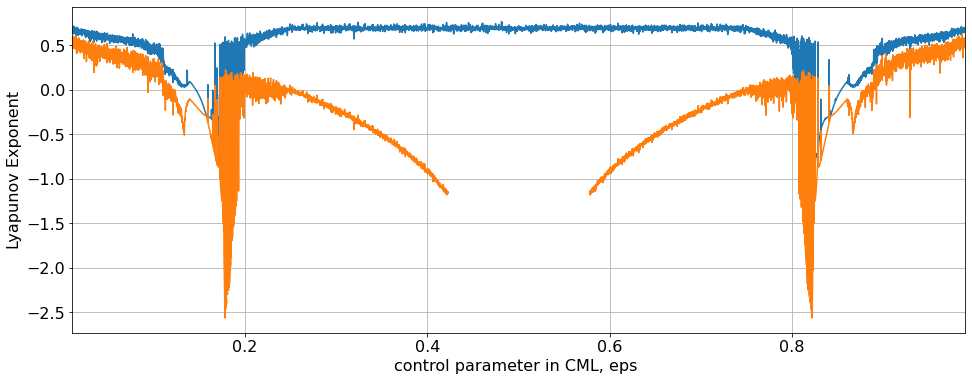

In [6]:
import matplotlib.pyplot as plt
# Plot all the spectrum
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel('control parameter in CML, eps ')
ax1.set_ylabel('Lyapunov Exponent')
#ax1.set_xticks()
ax1.set_xlim([epss[0],epss[-1]])
for k in range(lyp_spec_arr.shape[1]):
    ax1.plot(epss, lyp_spec_arr[:, k])
ax1.grid()

## 0.249< eps < 0.251 の間の図示


(1000, 2)


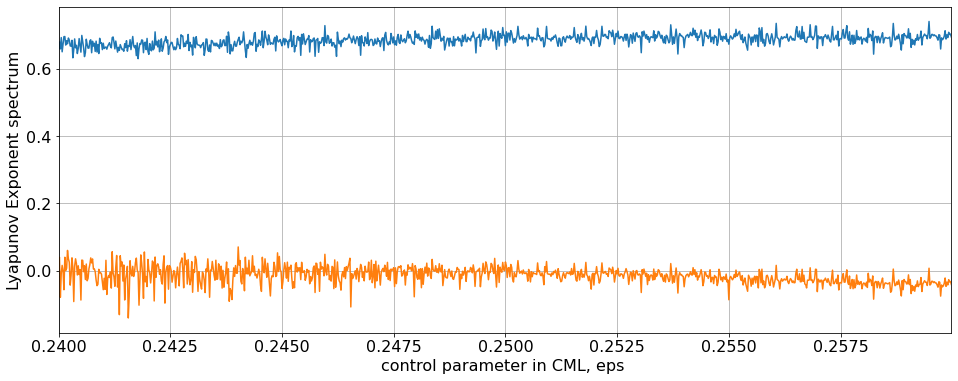

In [ ]:
pLow = 0.24
pHigh = 0.26
nSteps=1000
pInc = (pHigh - pLow) / nSteps
epss = np.arange(pLow, pHigh, pInc)

#np.random.seed(1010)

lyp_spec_arr=[]
for eps in epss:
  lyp_spec_arr.append(lyp_spectrum(eps=eps))

lyp_spec_arr = np.array(lyp_spec_arr)
print(lyp_spec_arr.shape)

import matplotlib.pyplot as plt
# Plot all the spectrum
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel('control parameter in CML, eps ')
ax1.set_ylabel('Lyapunov Exponent spectrum')
#ax1.set_xticks()
ax1.set_xlim([epss[0],epss[-1]])
for k in range(lyp_spec_arr.shape[1]):
    ax1.plot(epss, lyp_spec_arr[:, k])
ax1.grid()

## 二つの位置x, y 間の差のlyapunov指数
ヤコビアンは手計算で定義するのが慣習である。

しかし
差は一つ前の状態の差の関数という形で記述できない.(手計算により確認した.)

同様の理由で, 数値計算でもヤコビアンは導出できない.

プロットを線形近似するしかない(のでは?)

In [ ]:

def func1(r, x):
  return r*x*(1-x)

def logistic(a, x):
  return 1-(a*x)*x

def next_x(f, r, l, eps, x):
    x_new = np.empty(x.shape)
    for i in range(l):
        if i == 0:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i+1])
        elif i == l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i-1])
        elif i > 0 and i < l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + 0.5 * eps * (f(r,x[i-1]) + f(r,x[i+1]))
            #ここの0.5は必要か??
    return x_new


# formula
$
\begin{pmatrix}
\delta{x_{t}}\\
\delta{y_{t}}
\end{pmatrix}
=(\delta{x_{t}}+\delta{y_{t}})/\sqrt{2}
\times
\begin{pmatrix}
1/\sqrt{2}\\
1/\sqrt{2}
\end{pmatrix}
+
(\delta{x_{t}}-\delta{y_{t}})/\sqrt{2}
\times
\begin{pmatrix}
1/\sqrt{2}\\
-1/\sqrt{2}
\end{pmatrix}
$

$
=\delta_{X_{t}}
\times
\begin{pmatrix}
1/\sqrt{2}\\
1/\sqrt{2}
\end{pmatrix}
+
\delta_{Y_{t}}
\times
\begin{pmatrix}
1/\sqrt{2}\\
-1/\sqrt{2}
\end{pmatrix}
=\begin{pmatrix}
1/\sqrt{2} & 1/\sqrt{2}\\
1/\sqrt{2} & -1/\sqrt{2}
\end{pmatrix}
\times
\begin{pmatrix}
\delta_{X_{t}}\\
\delta_{Y_{t}}
\end{pmatrix}
=P
\begin{pmatrix}
\delta_{X_{t}}\\
\delta_{Y_{t}}
\end{pmatrix}
$

$
J
\begin{pmatrix}
\delta{x_{t}}\\
\delta{y_{t}}
\end{pmatrix}
=JP
\begin{pmatrix}
\delta_{X_{t}}\\
\delta_{Y_{t}}
\end{pmatrix}
=\begin{pmatrix}
\delta{x_{t+1}}\\
\delta{y_{t+1}}
\end{pmatrix}
=P
\begin{pmatrix}
\delta_{X_{t+1}}\\
\delta_{Y_{t+1}}
\end{pmatrix}
$

$
\begin{pmatrix}
\delta_{X_{t+1}}\\
\delta_{Y_{t+1}}
\end{pmatrix}
=P^{-1}
JP
\begin{pmatrix}
\delta_{X_{t}}\\
\delta_{Y_{t}}
\end{pmatrix}
$

In [7]:
from numpy import linalg as LA
import numpy as np
"""
x-y & x+y
手計算でヤコビアンを定義した.
"""
#dim_rv: length of state, like CML, GCM, ESN

delta=0.001

def Jocabi(r,eps, x):
  return r*np.array([[(1-eps)*(1-2*x[0]), eps*(1-2*x[1])],
                     [ eps*(1-2*x[0]), (1-eps)*(1-2*x[1]) ]])

def lyp_spectrum(dim_rv=2, num_steps=10, h=delta, r=4.0, eps=0.1):

  nTransients = 200   # The iterates we'll throw away
  nIterates = 500     # This sets how dense the bifurcation diagram will be
  ic = np.random.uniform(0.1, 0.9, dim_rv)  # random initial condition betn. (0,1)

  for i in range(nTransients):
    ic=next_x(func1, r, dim_rv, eps, ic)

  state_list=np.empty((nIterates, dim_rv))
  state_list[0]=ic
  for i in range(nIterates-1):
    state_list[i+1]=next_x(func1, r, dim_rv, eps, state_list[i])
  """
  states=np.empty((nIterates, dim_rv))
  states[0]=ic
  for i in range(nIterates-1):
    states[i+1]=next_x(func1, r, dim_rv, eps, states[i])
  state_list=np.array([states[:,0]-states[:,1], states[:,0]+states[:,1]])
  state_list=state_list.T
  print(state_list.shape)
  """
  lyp_spec = []
  
  P=np.array([[2**(-0.5), 2**(-0.5)],
              [2**(-0.5), -2**(-0.5)]])
  
  L = state_list.shape[0]
  dx_list=np.identity(dim_rv)*h
  for i in range(0, L, num_steps):
    ps_lyp = np.zeros(dim_rv)
    J=np.identity(dim_rv)
    for k in range(i, min(i+num_steps, L)):
      # Calculate the Jacobian matrix
      J_f = Jocabi(r, eps, state_list[k])
      #print(J_f)
      # Calculate the spectrum of the Jacobian matrix
      J=np.dot(J_f, J)
    #print(J)
    J=np.dot(J, P)
    J=np.dot(P**(-1), J)
    #print(J)
    A = np.dot(J, np.transpose(J))

    wa = LA.eigvalsh(A)
    ra = np.sqrt(np.abs(wa))
    #print(ra)
    idx = ra.argsort()[::-1]   
    ps_lyp = np.log(ra[idx]) /float(num_steps)#LLP

    lyp_spec.append(ps_lyp)
    #print(ps_lyp)
  lyp_spec = np.array(lyp_spec)
  #print(lyp_spec)#itinerary of LLP
  #print(lyp_spec.shape)
    
  # Take average spectrum overtime
  lyp_spec = np.mean(lyp_spec, axis=0)#GLP: average of LLP
  #print(lyp_spec.shape)
  return lyp_spec

print(lyp_spectrum(num_steps=10))

[0.55294618 0.32850512]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


(1000, 2)


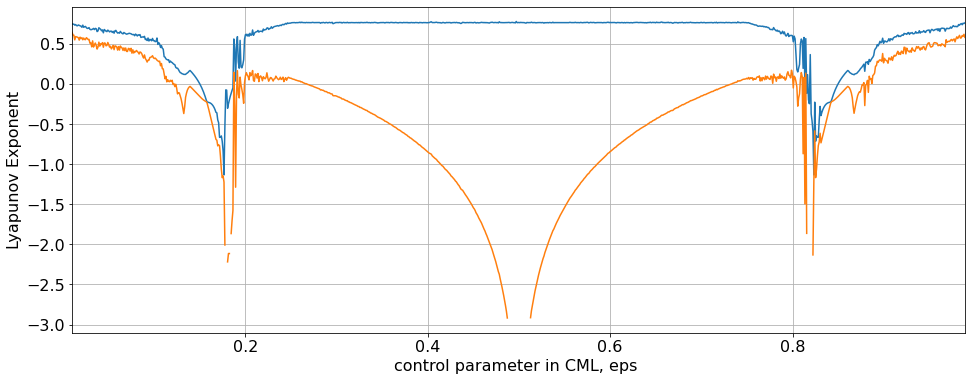

In [8]:
pLow = 0.01
pHigh = 0.99
nSteps=1000
pInc = (pHigh - pLow) / nSteps
epss = np.arange(pLow, pHigh, pInc)

lyp_spec_arr=[]
for eps in epss:
  lyp_spec_arr.append(lyp_spectrum(eps=eps))

lyp_spec_arr = np.array(lyp_spec_arr)
print(lyp_spec_arr.shape)

import matplotlib.pyplot as plt
# Plot all the spectrum
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel('control parameter in CML, eps ')
ax1.set_ylabel('Lyapunov Exponent')
#ax1.set_xticks()
ax1.set_xlim([epss[0],epss[-1]])
for k in range(lyp_spec_arr.shape[1]):
    ax1.plot(epss, lyp_spec_arr[:, k])
ax1.grid()

orange: transverse lyapunov exponent

0.2~0.8 では元論文とほとんど一致. その他の部分は一致しない.

0.1~0.2 付近では二値を動き回る挙動があり、これはカオスじゃないと思われるのでこの図で見られる負の値は正しそう. 
元論文ではなぜ滑らかな曲線で, かつ正なのか?


# 手計算でヤコビアンを定義した場合を示す.

In [ ]:

def func1(r, x):
  return r*x*(1-x)

def logistic(a, x):
  return 1-(a*x)*x

def next_x(f, r, l, eps, x):
    x_new = np.empty(x.shape)
    for i in range(l):
        if i == 0:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i+1])
        elif i == l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + eps * f(r,x[i-1])
        elif i > 0 and i < l - 1:
            x_new[i] = (1 - eps) * f(r,x[i]) + 0.5 * eps * (f(r,x[i-1]) + f(r,x[i+1]))
            #ここの0.5は必要か??
    return x_new


In [ ]:
from numpy import linalg as LA
import numpy as np
"""
ある特定のパラメータ下において、
十分長い時間領域におけるリャプノフ指数
を計算するのに特化している.
時系列は得られない.

リャプノフ指数の定義に従う.
"""
#dim_rv: length of state, like CML, GCM, ESN

delta=0.001

def Jocabi(r,eps, x):
  return r*np.array([[(1-eps)*(1-2*x[0]), eps*(1-2*x[1])],
                     [ eps*(1-2*x[0]), (1-eps)*(1-2*x[1]) ]])

def lyp_spectrum(dim_rv=2, num_steps=10, h=delta, r=4.0, eps=0.1):

  nTransients = 20   # The iterates we'll throw away
  nIterates = 200     # This sets how dense the bifurcation diagram will be
  ic = np.random.uniform(0.1, 0.9, dim_rv)  # random initial condition betn. (0,1)

  for i in range(nTransients):
    ic=next_x(func1, r, dim_rv, eps, ic)

  state_list=np.empty((nIterates, dim_rv))
  state_list[0]=ic
  for i in range(nIterates-1):
    state_list[i+1]=next_x(func1, r, dim_rv, eps, state_list[i])

  #print(state_list.shape)
  lyp_spec = []
    
  L = state_list.shape[0]
  dx_list=np.identity(dim_rv)*h
  for i in range(0, L, num_steps):
    ps_lyp = np.zeros(dim_rv)
    J=np.identity(dim_rv)
    for k in range(i, min(i+num_steps, L)):
      # Calculate the Jacobian matrix
      J_f = Jocabi(r, eps, state_list[k])
      #print(J_f)
      # Calculate the spectrum of the Jacobian matrix
      J=np.dot(J_f, J)
    #print(J)
    A = np.dot(J, np.transpose(J))

    wa = LA.eigvalsh(A)
    ra = np.sqrt(np.abs(wa))
    #print(ra)
    idx = ra.argsort()[::-1]   
    ps_lyp = np.log(ra[idx]) /float(num_steps)#LLP

    lyp_spec.append(ps_lyp)
    #print(ps_lyp)
  lyp_spec = np.array(lyp_spec)
  #print(lyp_spec)#itinerary of LLP
  #print(lyp_spec.shape)
    
  # Take average spectrum overtime
  lyp_spec = np.mean(lyp_spec, axis=0)#GLP: average of LLP
  #print(lyp_spec.shape)
  return lyp_spec

print(lyp_spectrum(num_steps=10))

[0.45871126 0.19250359]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


(10000, 2)


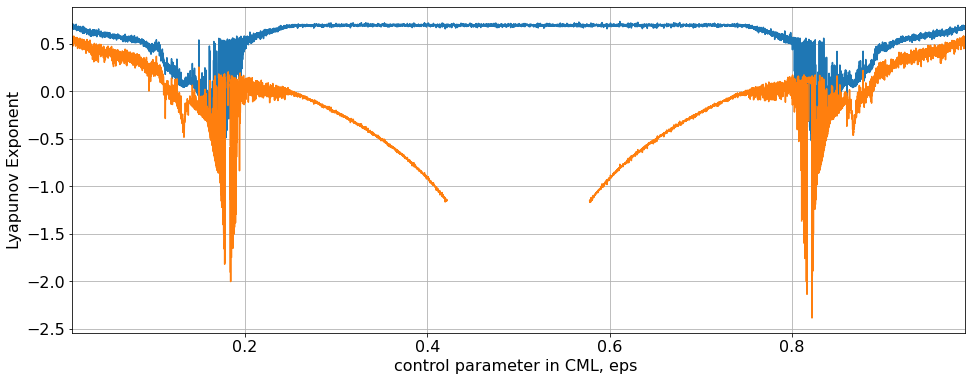

In [ ]:
import matplotlib.pyplot as plt
pLow = 0.01
pHigh = 0.99
nSteps=10000
pInc = (pHigh - pLow) / nSteps
epss = np.arange(pLow, pHigh, pInc)

lyp_spec_arr=[]
for eps in epss:
  lyp_spec_arr.append(lyp_spectrum(eps=eps))

lyp_spec_arr = np.array(lyp_spec_arr)
print(lyp_spec_arr.shape)


# Plot all the spectrum
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel('control parameter in CML, eps ')
ax1.set_ylabel('Lyapunov Exponent')
#ax1.set_xticks()
ax1.set_xlim([epss[0],epss[-1]])
for k in range(lyp_spec_arr.shape[1]):
    ax1.plot(epss, lyp_spec_arr[:, k])
ax1.grid()

# 1方向入力のCML